In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def read_dataset(fname):
    # 指定第一列作为行索引
    data = pd.read_csv(fname, index_col=0) 
    # 丢弃无用的数据
    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    # 处理性别数据
    data['Sex'] = (data['Sex'] == 'male').astype('int')
    # 处理登船港口数据
    labels = data['Embarked'].unique().tolist()
    data['Embarked'] = data['Embarked'].apply(lambda n: labels.index(n))
    # 处理缺失数据
    data = data.fillna(0)
    return data

train = read_dataset('datasets/titanic/train.csv')

In [3]:
# train.shape
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0
2,1,1,0,38.0,1,0,71.2833,1
3,1,3,0,26.0,0,0,7.9250,0
4,1,1,0,35.0,1,0,53.1000,0
5,0,3,1,35.0,0,0,8.0500,0


In [4]:
# 把Survived列提取出来作为标签，然后在原数据中将其丢弃。同时将数据集分为训练数据集和交叉验证数据集
from sklearn.model_selection import train_test_split

y = train['Survived'].values
X = train.drop(['Survived'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('train dataset: {0}; test dataset: {1}'.format(
    X_train.shape, X_test.shape))

train dataset: (712, 7); test dataset: (179, 7)


In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

train score: 0.9887640449438202; test score: 0.8156424581005587


从输出数据中可以看出，针对训练样本评分很高，但针对交叉验证数据集评分比较低，两者差距较大。很明显，这是过拟合的特征。解决决策树过拟合的方法是剪枝，包括前剪枝和后剪枝。不幸的是，scikit-learn不支持后剪枝，但提供一系列的模型参数进行前剪枝。例如，我们通过max_depth参数限定决策树的深度，当决策树达到限定的深度时，就不再进行分裂了。这样就可以在一定程度上避免过拟合。

In [15]:
from sklearn.tree import export_graphviz

with open("titanic.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)

# 1. 在电脑上安装 graphviz
# 2. 运行 `dot -Tpng titanic.dot -o titanic.png` 
# 3. 在当前目录查看生成的决策树 titanic.png

![titanic](titanic_1.png)

best param: 7; best score: 0.8268156424581006


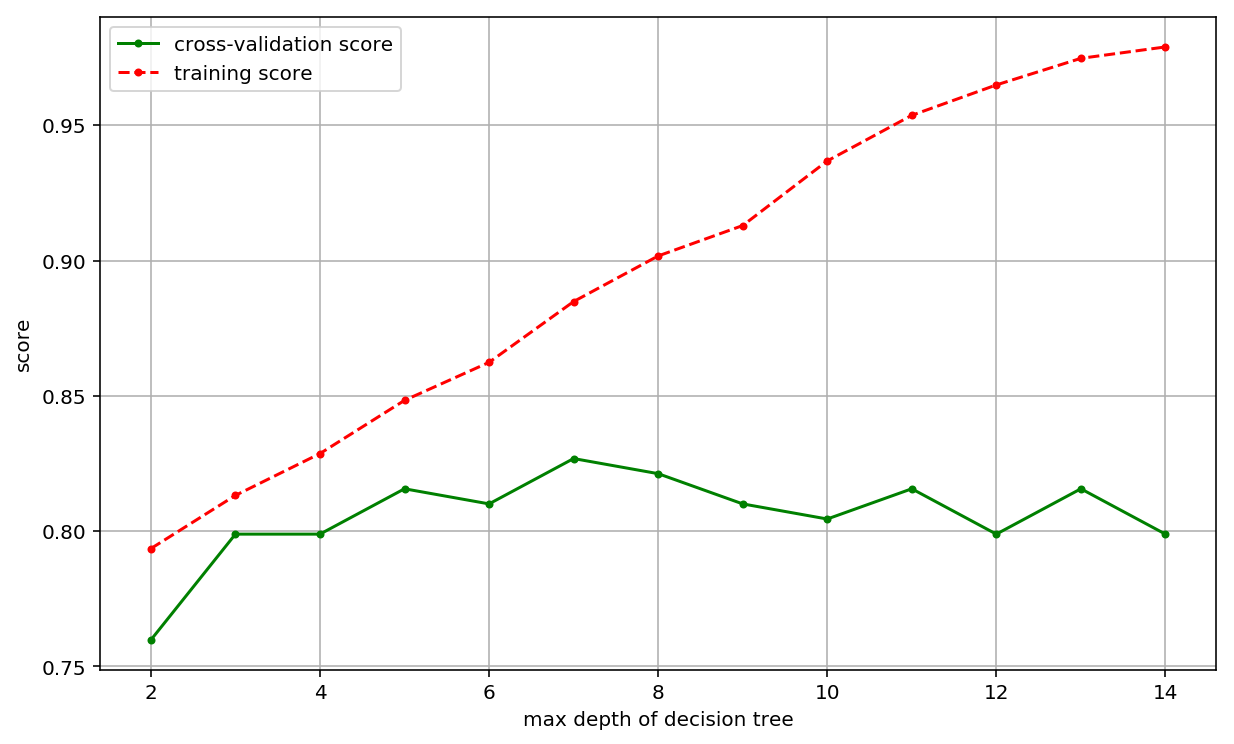

In [7]:
# 参数选择 max_depth
def cv_score(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

depths = range(2, 15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = depths[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g-', label='cross-validation score')
plt.plot(depths, tr_scores, '.r--', label='training score')
plt.legend()

best param: 0.0017346938775510204; best score: 0.8268156424581006


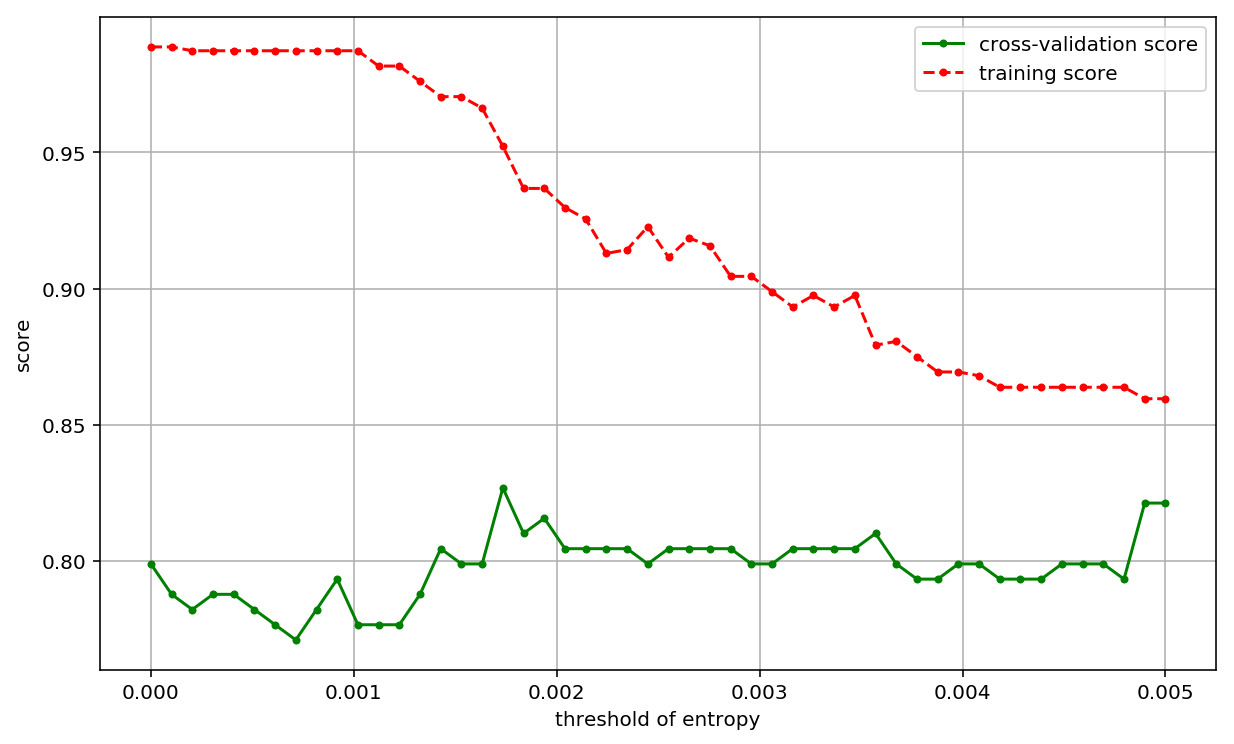

In [8]:
# 训练模型，并计算评分
def cv_score(val):
#     clf = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=val)
    clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=val)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

# 指定参数范围，分别训练模型，并计算评分
values = np.linspace(0, 0.005, 50)
scores = [cv_score(v) for v in values]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

# 找出评分最高的模型参数
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = values[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

# 画出模型参数与模型评分的关系
plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
# plt.xlabel('threshold of entropy')
plt.xlabel('threshold of entropy')
plt.ylabel('score')
plt.plot(values, cv_scores, '.g-', label='cross-validation score')
plt.plot(values, tr_scores, '.r--', label='training score')
plt.legend()

In [9]:
def plot_curve(train_sizes, cv_results, xlabel):
    train_scores_mean = cv_results['mean_train_score']
    train_scores_std = cv_results['std_train_score']
    test_scores_mean = cv_results['mean_test_score']
    test_scores_std = cv_results['std_test_score']
    plt.figure(figsize=(10, 6), dpi=144)
    plt.title('parameters turning')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '.--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

best param: {'min_impurity_decrease': 0.0012244897959183673}
best score: 0.8114478114478114


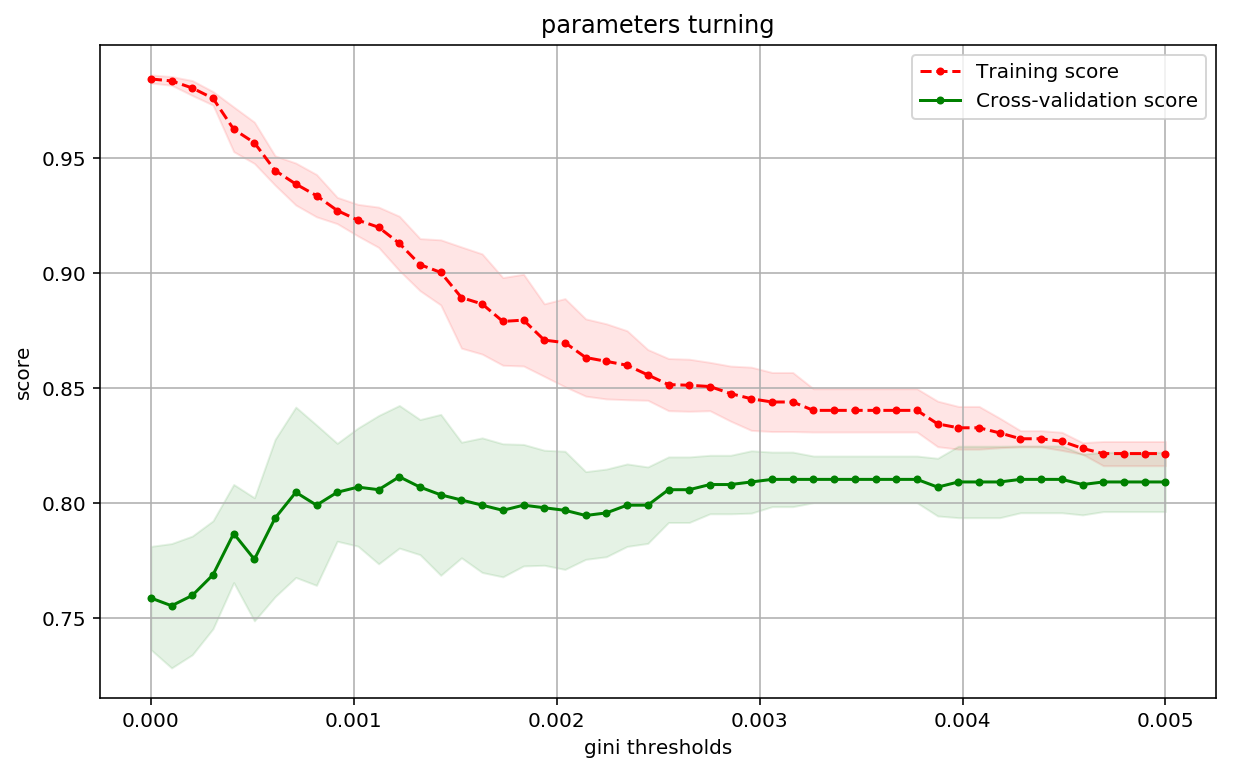

In [10]:
from sklearn.model_selection import GridSearchCV

thresholds = np.linspace(0, 0.005, 50)
# Set the parameters by cross-validation
param_grid = {'min_impurity_decrease': thresholds}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))

plot_curve(thresholds, clf.cv_results_, xlabel='gini thresholds')

In [11]:
from sklearn.model_selection import GridSearchCV

entropy_thresholds = np.linspace(0, 0.01, 50)
gini_thresholds = np.linspace(0, 0.005, 50)

# Set the parameters by cross-validation
param_grid = [{'criterion': ['entropy'], 
               'min_impurity_decrease': entropy_thresholds},
              {'criterion': ['gini'], 
               'min_impurity_decrease': gini_thresholds},
              {'max_depth': range(2, 10)},
              {'min_samples_split': range(2, 30, 2)}]

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
clf.fit(X, y)
print("best param: {0}\nbest score: {1}".format(clf.best_params_, 
                                                clf.best_score_))

best param: {'criterion': 'entropy', 'min_impurity_decrease': 0.002857142857142857}
best score: 0.8226711560044894


## 生成决策树图形

In [12]:
clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.002857142857142857)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

# 导出 titanic.dot 文件
with open("titanic.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)

# 1. 在电脑上安装 graphviz
# 2. 运行 `dot -Tpng titanic.dot -o titanic.png` 
# 3. 在当前目录查看生成的决策树 titanic.png

train score: 0.9101123595505618; test score: 0.7877094972067039


![titanic](titanic_2.png)